# 使用现实数据
# 看着大图
## 看待问题
## 选择一个评估手段
## 验证假设
# 获取数据
## 建立工作
## 下载数据

自动获取目标地址数据：

In [9]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [10]:
fetch_housing_data()

In [11]:
# load data
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [12]:
#Quick Look at the Data
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
housing.info()
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [14]:
housing["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

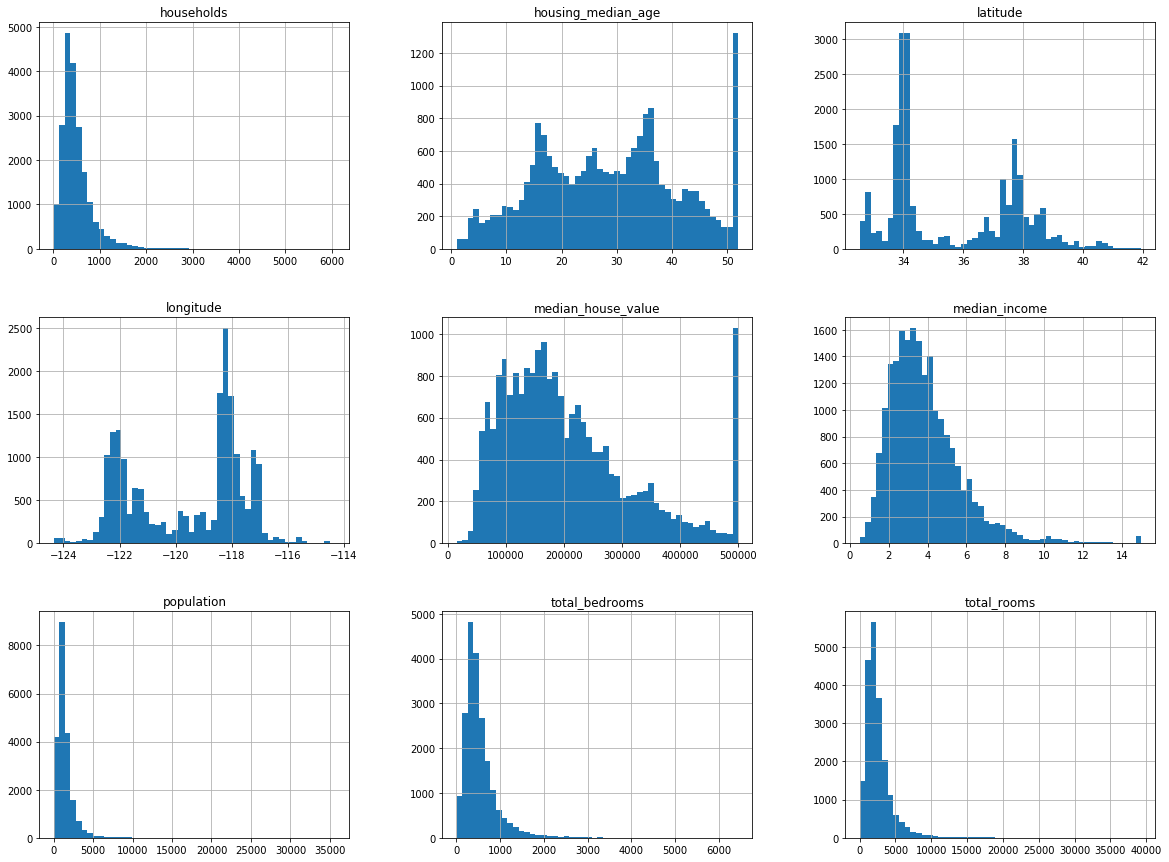

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

从上面柱状图可以发现：  
1.The median income(平均收入)是被预处理过的数据，并不是以美元表示，这不影响学习结果；  
2.housing median age和median house value这两项被截断了，这是一个严重的问题，因为这会使学习结果严重失真，有两种处理方法：  
a.对截断部位使用合适的标记；  
b.移除截断部位的分布，但是这会导致模型无法预测该区间；  
3.这些分部区间相去甚远；  
4.分部不均，这使得机器学习难以发现其中的模式，需要转化为钟型。  
## 创建一个测试集

### 纯随机划分

In [16]:
#使用np.random区分
import numpy as np
np.random.seed(42)
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
    
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

#使用hashlib区分，有利于在更新数据集时，保持原有划分
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
    
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()  #add an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set), "train +", len(test_set), "test")

#使用sklearn的split方法
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test
16362 train + 4278 test
16512 train + 4128 test


### 根据分布划分

In [17]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1 ,test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
housing["income_cat"].value_counts() / len(housing)

#remove the income_cat so the data is back to its original state
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## 数据可视化及探索数据

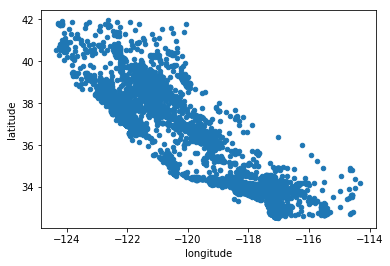

In [18]:
#制作一个副本，避免对原始数据集做改动
housing = strat_train_set.copy()

#对于地理数据，一个好主意就是将数据做成点图：
housing.plot(kind="scatter", x="longitude", y="latitude")

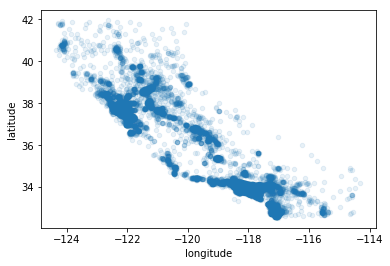

In [19]:
#上面的图对密度不是表现的很清楚，加入alphabsa参数
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

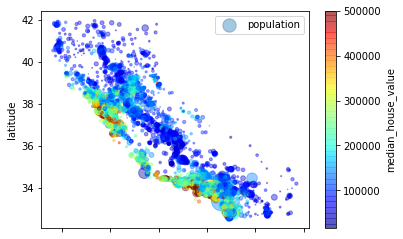

In [20]:
#还可以加入多种元素的可视化
housing.plot.scatter(x="longitude", y="latitude", alpha=0.4,
    s=housing['population']/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)




## 观察相关系数

In [21]:
#在数据集不太大的情况下，可以使用standard correlation coefficientabs计算各种变量的相关系数

corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D4F3569860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001D4E975F320>]], dtype=object)

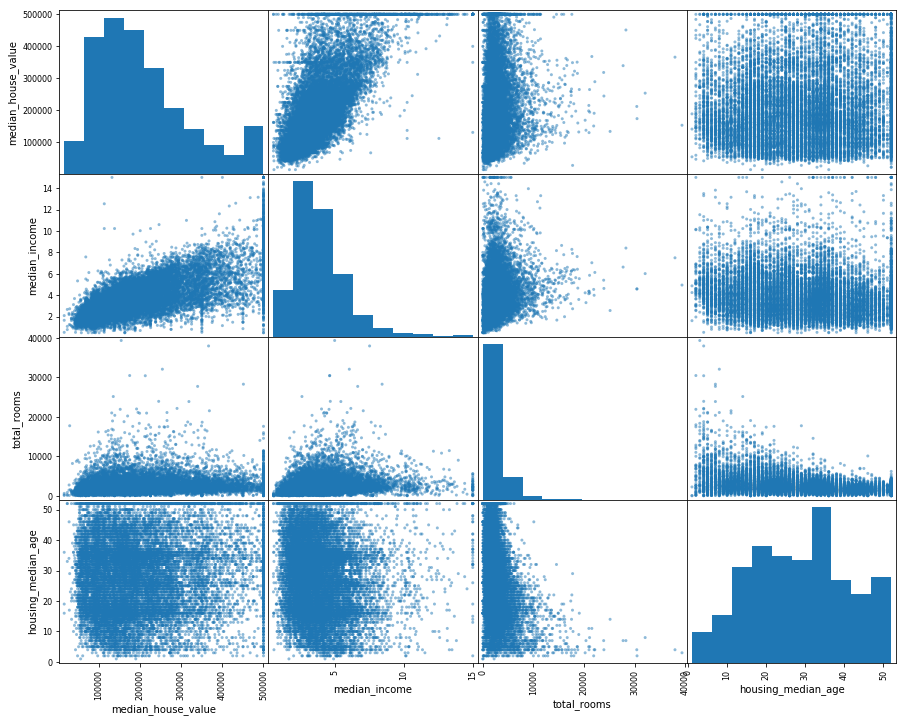

In [22]:
#或者用图形表示
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', "median_income", "total_rooms",
    "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(15,12))

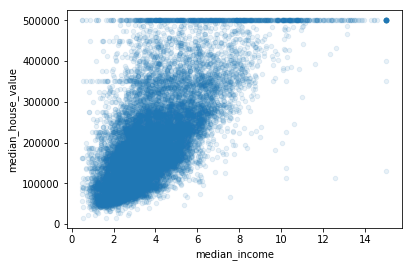

In [23]:
housing.plot.scatter(x='median_income', y='median_house_value', alpha=0.1)

In [24]:
#还可以将不同特征组合，得到新特征
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## 为机器学习算法准备数据

In [25]:
#首先要将目标数据从整个数据集分离出来：
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### 数据清理
我们注意到total_bedrooms分布有缺失数据，面对这种情况，我们有三种选择：  
1.忽视这部分数据；  
2.忽视整个分布；  
3.插值。

In [26]:
housing.dropna(subset=['total_bedrooms'])    #option 1
housing.drop('total_bedrooms', axis=1)       #option 2

median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median)     #option 3

#option 3还有专门的sklearn方法
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')         

#median方法只适用于数值型，原数据集只有'ocean_proximity'是文本型，所以先将其去掉，对                                                #原数据集做处理，我们需要对整个数据集处理，因为新数据可能在任何一个位置丢失数据
housing_num = housing.drop('ocean_proximity', axis=1)

imputer.fit(housing_num)

X = imputer.transform(housing_num)    
#这里的结果是Numpy array类型，若要转化为Pandas DataFrame,如下

housing_tr = pd.DataFrame(X, columns=housing_num.columns)

对文本数据或者特征属性做数据清理：标签量化


In [36]:
#LabelEncoder方法
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

#use classes_ to look at the mapping
print(encoder.classes_)

#各标签间的距离不一样，故使用onehot解决
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

得到的是Scipy sparse matrix，而不是Numpy array，这对于大量数据十分有利，这种存储方式只记录每行唯一的1所在的位置，可以使用toarray()查看,这种编码方式还有数据扩维的意思。

In [28]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

我们还能够使用labelbinarizer方法实现onehot

In [70]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=False)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### 创建自己的类

In [30]:
from sklearn.base import BaseEstimator,TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedroom_per_room = True):     # no *args or **kargs
        self.add_bedroom_per_room = add_bedroom_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedroom_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedroom_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### 特征归一化(Feature Scaling)

两种方法：  
1.min-max scaling:MinMaxScaler,默认feature_range为0-1  
2.standardization:将数组中值移至0，除以方差使得方差为单位值。StandardScaler

### 变换流水线(Transformation Pipelines)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',Imputer(strategy='median')),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

这是数值型的pipeline,非数值型的可以利用FeatureUnion方法：

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer',Imputer(strategy='median')),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [35]:
housing_prepared.shape

(16512, 16)

## 选择及训练一个模型
### 在训练集上训练和验证

#### 线性回归

In [37]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


使用RMSE度量:

In [44]:
from sklearn.metrics import mean_squared_error
housing_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

#### 决策树

In [47]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_prediction = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_prediction)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

过拟合，因此需要用更好的评价手段:交叉验证(Cross-Validation)

In [52]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([ 71345.18090449,  66440.11114387,  70858.09633964,  68920.65430084,
        70829.50965751,  74039.58655359,  69928.5218391 ,  69174.36176812,
        75494.67338852,  70017.32788332])

In [55]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 71345.18090449  66440.11114387  70858.09633964  68920.65430084
  70829.50965751  74039.58655359  69928.5218391   69174.36176812
  75494.67338852  70017.32788332]
Mean: 70704.8023779
Standard deviation: 2435.18053123


In [56]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)

line_rmse_scores = np.sqrt(-lin_scores)
display_scores(line_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


### 保存一个模型  
使用
from sklearn.externals import joblib

joblib.dump(my_model, "my_model.pkl")

my_model_loaded = joblib.load("my_model.pkl")

## 改善你的模型

### 网格搜索(Grid Search)

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#搜索先按照第一个字典条目的组合12个，然后在按照下面的6个
param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'max_features': [2, 3, 4], 'bootstrap': [False], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [58]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [59]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [60]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64780.1854129 {'max_features': 2, 'n_estimators': 3}
55329.0822092 {'max_features': 2, 'n_estimators': 10}
53112.2859516 {'max_features': 2, 'n_estimators': 30}
59253.2204575 {'max_features': 4, 'n_estimators': 3}
52536.9952185 {'max_features': 4, 'n_estimators': 10}
50668.6475155 {'max_features': 4, 'n_estimators': 30}
59154.2487044 {'max_features': 6, 'n_estimators': 3}
52157.577033 {'max_features': 6, 'n_estimators': 10}
50191.9499459 {'max_features': 6, 'n_estimators': 30}
59430.1109153 {'max_features': 8, 'n_estimators': 3}
52749.6017027 {'max_features': 8, 'n_estimators': 10}
50132.445887 {'max_features': 8, 'n_estimators': 30}
62423.8314122 {'max_features': 2, 'bootstrap': False, 'n_estimators': 3}
54998.2207928 {'max_features': 2, 'bootstrap': False, 'n_estimators': 10}
60049.7610974 {'max_features': 3, 'bootstrap': False, 'n_estimators': 3}
52301.7315826 {'max_features': 3, 'bootstrap': False, 'n_estimators': 10}
59128.4427674 {'max_features': 4, 'bootstrap': False, 'n_estimat

### 随机搜索
如果搜索空间较大，通常使用随机搜索(Randomized Search)代替

### 组合方法(Ensemble Methods)
使用弱学习器组合成强学习器

### 分析最佳模型和误差

In [71]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_romm"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33277530401681871, 'median_income'),
 (0.1694567494700111, 'INLAND'),
 (0.10872402353339501, 'pop_per_hhold'),
 (0.076035346034275961, 'longitude'),
 (0.075776239948381355, 'bedrooms_per_romm'),
 (0.066129273544626901, 'latitude'),
 (0.054713523298314373, 'rooms_per_hhold'),
 (0.042426249552740998, 'housing_median_age'),
 (0.014763339948935722, 'total_rooms'),
 (0.014622133115310231, 'population'),
 (0.014545574881365937, 'total_bedrooms'),
 (0.014297626609380434, 'households'),
 (0.0090527622348402347, '<1H OCEAN'),
 (0.0033922574233089492, 'NEAR OCEAN'),
 (0.0031944497697329387, 'NEAR BAY'),
 (9.5146618561173528e-05, 'ISLAND')]

## 在测试集上评估模型 

In [75]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47438.44578320624